# Toxic comments



In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.svm import LinearSVC

fn = '/Users/marcinia/Downloads/ml-master/final_assignment_1/toxiccomments_train.csv'

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# Stop words I want to remove  
someStopWords = text.ENGLISH_STOP_WORDS.difference(['off', 'all',
                                                    'because',
                                                    'been',
                                                    'every',
                                                    'for',
                                                    'get',
                                                    'give',
                                                    'her',
                                                    'hers',
                                                    'his',
                                                    'made',
                                                    'me',
                                                    'move',
                                                    'my',
                                                    'never',
                                                    'no',
                                                    'not',
                                                    'nowhere',
                                                    'off',
                                                    'put',
                                                    'see',
                                                    'should',
                                                    'some',
                                                    'someone',
                                                    'then',
                                                    'under',
                                                    'when',
                                                    'why',
                                                    'you',
                                                    'your',
                                                    'yours',
                                                    'yourself',
                                                    'yourselves',
                                                    'ma'])

In [10]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)


    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        #vectorizer = CountVectorizer(stop_words='english')
        #X_vec = vectorizer.fit_transform(toxic_data.comment_text)
        #fitted_transformations.append(X_vec)
        #X_vec = fitted_transformations[0].transform(toxic_data.comment_text)


        # Hashing Vectorizer 
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, stop_words='english')
        X_hv = hv.fit_transform(toxic_data.comment_text, someStopWords)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_hv, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [11]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/marcinia/Downloads/ml-master/final_assignment_1/toxiccomments_train.csv', my_random_seed=81)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [ ]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 6380, 'TN': 59464, 'FP': 55185, 'FN': 6627, 'Accuracy': 0.5157924421883813, 'Precision': 0.10363030942905872, 'Recall': 0.49050511263165986, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [12]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13070, 'Neg': 114586, 'TP': 12967, 'TN': 114484, 'FP': 102, 'FN': 103, 'Accuracy': 0.9983941217020743, 'Precision': 0.9921952712525824, 'Recall': 0.9921193573068094, 'desc': 'svm_train'}


### MODEL: logistic regression

In [13]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13070, 'Neg': 114586, 'TP': 12955, 'TN': 114510, 'FP': 76, 'FN': 115, 'Accuracy': 0.9985037914394936, 'Precision': 0.9941677538178191, 'Recall': 0.9912012241775058, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 12749, 'TN': 103299, 'FP': 11350, 'FN': 258, 'Accuracy': 0.9090681205740427, 'Precision': 0.5290261006680775, 'Recall': 0.9801645267932652, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [14]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13070, 'Neg': 114586, 'TP': 12950, 'TN': 114502, 'FP': 84, 'FN': 120, 'Accuracy': 0.9984019552547472, 'Precision': 0.9935553168635876, 'Recall': 0.9908186687069626, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [ ]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13007, 'Neg': 114649, 'TP': 10947, 'TN': 114470, 'FP': 179, 'FN': 2060, 'Accuracy': 0.9824606755655825, 'Precision': 0.9839115585115945, 'Recall': 0.8416237410625048, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13007, 'Neg': 114649, 'TP': 0, 'TN': 114649, 'FP': 0, 'FN': 13007, 'Accuracy': 0.8981089803847842, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/home/ec2-user/ml/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

In [16]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

NameError: name 'nbs_performance_train' is not defined

### let's look at some false positives:

In [17]:
prc_t = prc.predict(X_train)

In [18]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(prc_t)):
    if (prc_t[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
19426
There was something boring here before
* * * * * * * * * 
29457
"

How I rid of this ""new"" message? its really annoying because its the same message over and over - get rid of this plz"
* * * * * * * * * 
30088
Why do you hate him or her?
* * * * * * * * * 
73065
A sockpuppet leave me alone.
* * * * * * * * * 
102117
hey you're just mad cause you know its true.
* * * * * * * * * 


# Look at performance on the test set

### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3155, 'Neg': 28760, 'TP': 1993, 'TN': 27303, 'FP': 1457, 'FN': 1162, 'Accuracy': 0.9179382735390882, 'Precision': 0.5776811594202899, 'Recall': 0.6316957210776545, 'desc': 'prc_test'}


### MODEL: SVM, linear

In [27]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3155, 'Neg': 28760, 'TP': 2024, 'TN': 27246, 'FP': 1514, 'FN': 1131, 'Accuracy': 0.917123609587968, 'Precision': 0.5720746184284907, 'Recall': 0.6415213946117274, 'desc': 'svm_test'}


### MODEL: logistic regression

In [23]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3155, 'Neg': 28760, 'TP': 2014, 'TN': 27188, 'FP': 1572, 'FN': 1141, 'Accuracy': 0.9149929500234999, 'Precision': 0.5616285554935861, 'Recall': 0.6383518225039619, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [ ]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3218, 'Neg': 28697, 'TP': 2088, 'TN': 23600, 'FP': 5097, 'FN': 1130, 'Accuracy': 0.804887983706721, 'Precision': 0.2906054279749478, 'Recall': 0.6488502175264139, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [21]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3155, 'Neg': 28760, 'TP': 1993, 'TN': 27303, 'FP': 1457, 'FN': 1162, 'Accuracy': 0.9179382735390882, 'Precision': 0.5776811594202899, 'Recall': 0.6316957210776545, 'desc': 'prc_test'}


### ROC plot to compare performance of various models and fits

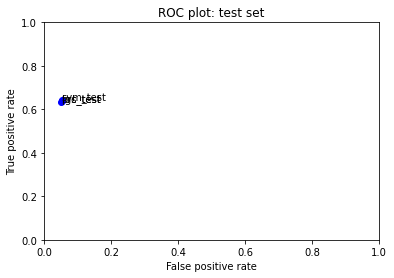

In [28]:
fits = [svm_performance_test, lgs_performance_test, prc_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [26]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/marcinia/Downloads/ml-master/final_assignment_1/toxiccomments_test.csv', my_random_seed=81, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6           1
8         109           9
9          41         

In [29]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.21271969914601344


In [30]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [31]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [32]:
my_submission.shape

(153164, 2)

In [33]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/marcinia/Downloads/ml-master/final_assignment_1/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation